# Adding Foregrounds to the Simulated CMB
### Jeff McMahon and Renée Hložek 

The previous notebook simulated a purely CMB realisation of the sky. We now want to add in foregrounds to the CMB map. We will start by reading in the parameters we defined in the previous notebook.

In [1]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits


%matplotlib inline
#%cd /Your/location/to/the/directory
import constants as cs # the constants module
from cmb_modules import * # the module of functions
N = cs.N
c_min = cs.c_min
c_max = cs.c_max
X_width =cs.X_width
Y_width = cs.Y_width

pix_size = cs.pix_size

## Section 1.3: Point Source Map

Point sources in CMB maps arise from a number of astrophysical objects including Active Galactic Nuclei (AGN), Dust Star Forming Galaxies (DSFGs), and a bright tail of lensed DSFGs.  All of theses objects are interesting in their own right.  For the purposes of our mock skies we approximate these populations as a combination of a faint distribution of sources with a poisson distribution of brightness and small number of very bright sources with an exponentially falling source count.   This approximates the distribution of faint and bright sources seen in real CMB maps.   The source parameters were chosen by eye to look about the same as real maps at 150 GHz.   Detailed source counts have been published and can be consulted to add more reality into these simulations.  Publications also detail the frequency scalings of these sources.  In general DSFGs grow brighter at higher frequencies while AGNs have a spectrum that falls with increasing frequencies.  These behaviors must be included in multifrequency analyses and simulations.

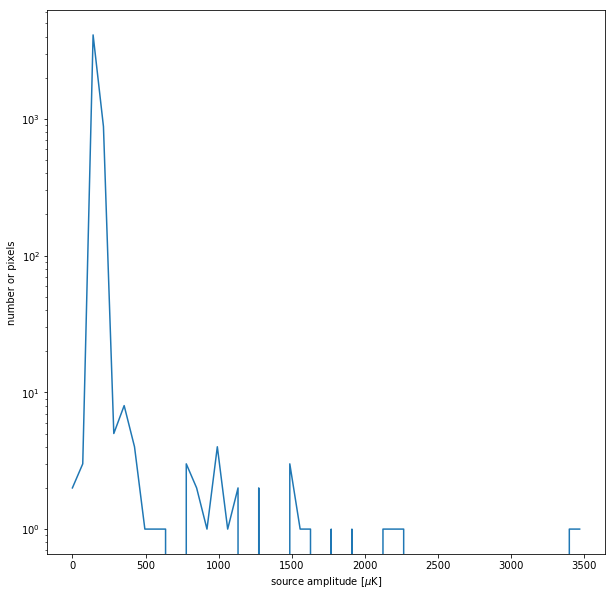

map mean: 0.997309304103402 map rms: 16.27314911759349


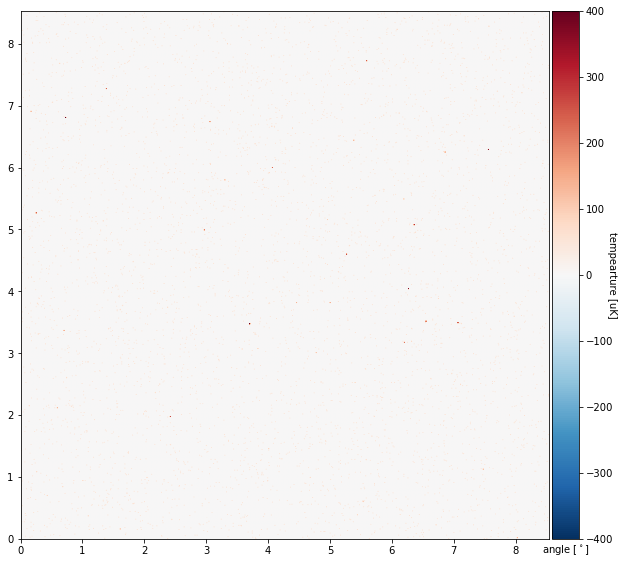

In [2]:
### paramaters to set up the Poisson point source distribution
Number_of_Sources  = 5000.
Amplitude_of_Sources = 200.
Number_of_Sources_EX = 50.
Amplitude_of_Sources_EX = 1000.

def Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources):
    "makes a realization of a naive Poisson-distributed point source map"
    "takes in the number of pixels, the size of the pixels and the number and amplitude of the sources"
    PSMap = np.zeros([int(N),int(N)])
    i = 0.
    # we throw random numbers repeatedly with amplitudes given by a Poisson distribution around the mean amplitude
    while (i < Number_of_Sources):
        pix_x = int(N*np.random.rand())
        pix_y = int(N*np.random.rand()) 
        PSMap[pix_x,pix_y] += np.random.poisson(Amplitude_of_Sources)
        i = i + 1

    return(PSMap)    
  ############################### 

def Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX):
    "makes a realization of a naive exponentially-distributed point source map"
    PSMap = np.zeros([int(N),int(N)])
    i = 0.
    # we throw random numbers repeatedly with amplitudes given by an exponential distribution around the mean amplitude
    while (i < Number_of_Sources_EX):
        pix_x = int(N*np.random.rand()) 
        pix_y = int(N*np.random.rand()) 
        
        PSMap[pix_x,pix_y] += np.random.exponential(Amplitude_of_Sources_EX)
        i = i + 1

    return(PSMap)    
  ############################### 
    
## make a point source map

PSMap = Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
PSMap +=  Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)

hist,bin_edges = np.histogram(PSMap,bins = 50,range=[.001,PSMap.max()])
plt.figure(figsize=(10,10))
plt.semilogy(bin_edges[0:-1],hist)
plt.xlabel('source amplitude [$\mu$K]')
plt.ylabel('number or pixels')
plt.show()

p=Plot_CMB_Map(PSMap,c_min,c_max,X_width,Y_width)    

The top plot shows a histogram of brightness of the pixels in our source map.   The lower plot shows a map of the point source map we have simulated.

<font color='red'>EXCERCISE: </font> Plot a histogram of the Poisson sources and a histogram of the exponetial sources.   How do these two distributions differ?

In [3]:
## your code goes here

Your discussion goes here

## Section 1.4: SZ Map

Clusters of galaxies imprint a subtle distortion into CMB maps that is most apparent on arcminute scales.    While clusters of galaxies are named after the galaxies bound within them, the galaxies represent only a small fraction of the matter contained within a cluster.   Roughly 80% of the baryons are not contained within galaxies, but rather exist as a cloud of gas bound within the gravitational potential well created by a dark matter halo that caries the vast majority of the mass of the cluster.  Within this well, the dilute gas becomes ionized and heated to temperatures of millions of Kelvin.  Occasionally a CMB photon interacts with one of the hot electrons in this ionized gas.  This interaction (inverse Compton scattering) gives the CMB photon a boost in energy.  Detailed calculations show that this effect (the Sunyev-Zeldovich or SZ effect) leads to decrement of power at frequencies below the 'null' at 220 GHz and extra power at higher frequencies.  This result is redshift independent.  Thus the SZ effect provides a clean way to detect clusters of galaxies and the signal which traces the electron density within the cluster.  The SZ signal is a reasonably good tracer of cluster mass.

For these simulations we treat each cluster as having a brightness "beta profile", and fix each cluster to have an identical angular size.  We draw the distribution of central temperatures from the exponential distribution to simplify the code and reduce the dependance on external libraries.  For more accurate simulations, a range of clusters sizes should be used, a distribution of cluster shapes (with more accurate profiles) should be considered, and the number of clusters as a function of mass and redshift should be chosen to match measurements of the cluster mass function.

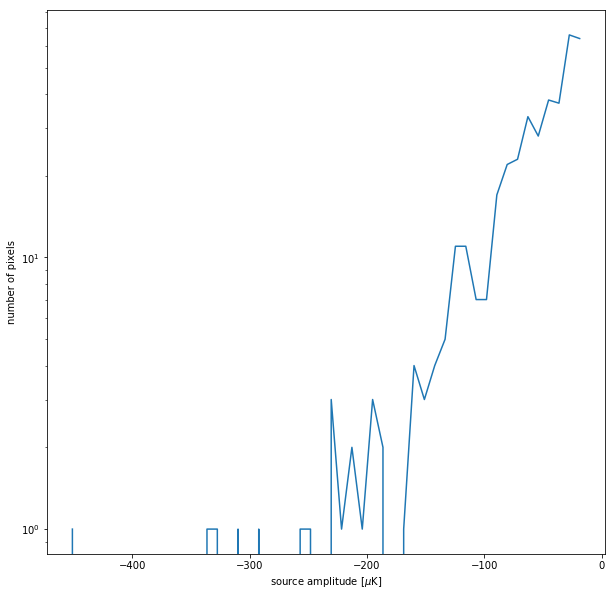

map mean: -13.769177880362763 map rms: 7.340462510188675


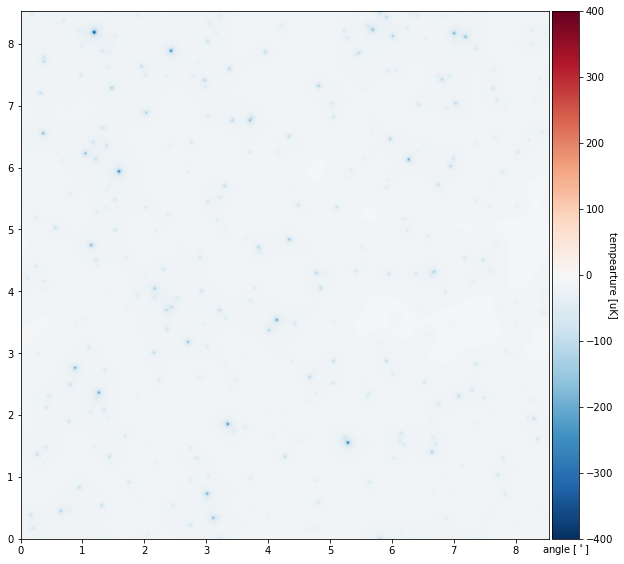

In [4]:
### paramaters to set up the SZ point sources
Number_of_SZ_Clusters  = 500
Mean_Amplitude_of_SZ_Clusters = 50
SZ_beta = 0.86
SZ_Theta_core = 1.0

def SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,do_plots):
    "makes a realization of a naive SZ map"
    N=int(N)
    SZMap = np.zeros([N,N])
    SZcat = np.zeros([3,Number_of_SZ_Clusters]) ## catalogue of SZ sources, X, Y, amplitude
    # make a distribution of point sources with varying amplitude
    i = 0
    while (i < Number_of_SZ_Clusters):
        pix_x = int(N*np.random.rand())
        pix_y = int(N*np.random.rand())
        pix_amplitude = np.random.exponential(Mean_Amplitude_of_SZ_Clusters)*(-1.)
        SZcat[0,i] = pix_x
        SZcat[1,i] = pix_y
        SZcat[2,i] = pix_amplitude
        SZMap[pix_x,pix_y] += pix_amplitude
        i = i + 1
    if (do_plots):
        hist,bin_edges = np.histogram(SZMap,bins = 50,range=[SZMap.min(),-10])
        plt.figure(figsize=(10,10))
        plt.semilogy(bin_edges[0:-1],hist)
        plt.xlabel('source amplitude [$\mu$K]')
        plt.ylabel('number of pixels')
        plt.show()
    
    # make a beta function
    beta = beta_function(int(N),pix_size,SZ_beta,SZ_Theta_core)
    
    # convolve the beta function with the point source amplitude to get the SZ map
    # NOTE: you should go back to the Intro workshop for more practice with convolutions!
    FT_beta = np.fft.fft2(np.fft.fftshift(beta))
    FT_SZMap = np.fft.fft2(np.fft.fftshift(SZMap))
    SZMap = np.fft.fftshift(np.real(np.fft.ifft2(FT_beta*FT_SZMap)))
    
    # return the SZ map
    return(SZMap,SZcat)    
  ############################### 

def beta_function(N,pix_size,SZ_beta,SZ_Theta_core):
  # make a beta function

    N=int(N)
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) * pix_size
    X = np.outer(ones,inds)
    Y = np.transpose(X)
    # compute the same real-space R function as before for the PS
    R = np.sqrt(X**2. + Y**2.)
    
    beta = (1 + (R/SZ_Theta_core)**2.)**((1-3.*SZ_beta)/2.)

    # return the beta function map
    return(beta)
  ############################### 
    
## make a point source map

SZMap,SZCat = SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,True)

  
p=Plot_CMB_Map(SZMap,c_min,c_max,X_width,Y_width)

The top plot shows the a histogram of the SZ-decrements from our simulated SZ cluster map.  The bottom plot shows our simulated SZ map. This map is at 150 GHz. How could you tell just from looking at the code above?

<font color='red'>EXCERCISE: </font>  In reality the cluster radii vary from cluster to cluster.  For reference the radius depends on redshift and mass.  The number of clusters as a function of mass and redshift is called the cluster 'mass function' which is a sensitive cosmological proble.  

To enhance the realism of our sims, divide the simulated cluster sample into an extremely large radius sample (1 cluster with a 30 arcminute radius, comparable to the Comma cluster; the largest cluster on the sky), a large radius bin (10%) clusters with 5 arcminute radius), a medium bin (30%) with 2 arcminute radius, and a small bin (60% with 0.5 arcminute radius).  

In [5]:
# your code goes here

Comment on whether or not your map looks reaosnable.   Also explain why (given the algorithm we are using) we didn't draw the cluster radius from a continuous distribution.

## 1.5 Full Sky Map

The sky map is a combination of the CMB anisotropy, a point source map, and an SZ map.  In an appendix we add the impact of CMB lensing.

map mean: -15.78761199659153 map rms: 102.04286565041069


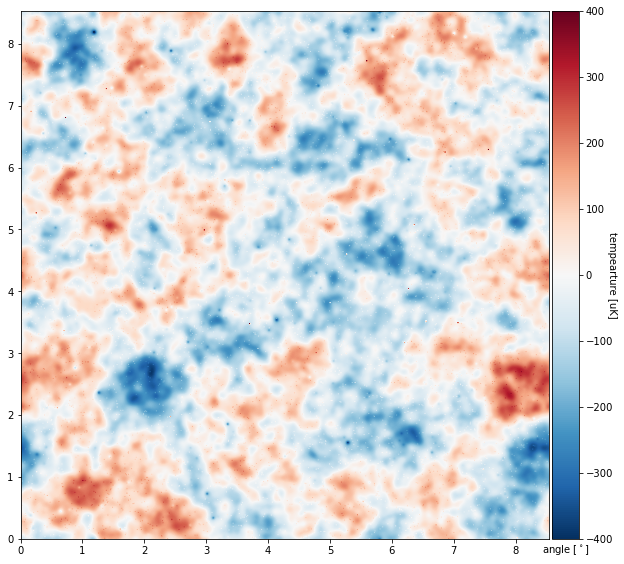

In [6]:
## remake the CMB map from the pervious excercise
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)

## add all the componets together
total_map = CMB_T + PSMap + SZMap

p=Plot_CMB_Map(total_map,c_min,c_max,X_width,Y_width)

This plot shows our simulated map that includes CMB, point source, and SZ cluster signals.  Note that the sources seem brighter than what we saw in the real observed maps.   This is not a mistake, as will be seen after we fold in the beam (point spread function) of the instrument.